# COGS 108 - Data Checkpoint

# Names

- Feifan Li
- Kexin Cheng
- Kesin Chang
- Ziyue Chen

<a id='research_question'></a>
# Research Question

Does the number of people vaccinated in different countries have an effect on the number of new confirmed cases of COVID-19 of those countries?

# Dataset(s)

<h5> Vaccination Rate </h5>

<ol> https://github.com/owid/covid-19-data/blob/master/public/data/vaccinations/vaccinations.csv <br> </ol>

<ol> 1738 observations from 2020/12/13 till 2/3/2021 <br> </ol>

<ol> The variables are location, number of people get vaccines, daily people get vaccines etc. This dataset basically collects people from different countries get vaccined over time</ol>

<ol> Collected by WWO, Stored in csv</ol>

<h5> World New Cases Data </h5>

<ol> https://github.com/owid/covid-19-data/blob/master/public/data/jhu/new_cases.csv <br> </ol>

<ol> 386 observations till 02/10/2021 <br> </ol>

<ol> The variables are date, total new cases around the world, and new cases broken down by 198 countries</ol>

<ol> Collected by Johns Hopkins University, Stored in csv</ol>

<h5> Weekly Data </h5>

<ol> https://github.com/owid/covid-19-data/blob/master/public/data/jhu/biweekly_cases.csv <br> </ol>

<ol> 371 observations till 1/28/2021 <br> </ol>

<ol> The variables are country name and the date.</ol>

<ol> Collected by Johns Hopkins University, Stored in csv</ol>

# Setup

In [2]:
# import library
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# import statmodels & patsy
import patsy
import statsmodels.api as sm

# supress warnings
import warnings
warnings.filterwarnings('ignore')

# improve resolution
%config InlineBackend.figure_format ='retina'
plt.rcParams['figure.figsize'] = (17, 7)

# Data Cleaning

## Vaccination Rate
For this data set, we need drop a few columns that we will not use for this project like raw vaccinations rate or vaccinations rate per-million.And since we want to use country's full name instead of abbreviation, we also drop the 'iso_code' column. After that, in some small countries, they provide limited amounts of data (many missing values), which may negatively influence our data interpretation. Hence, we decide to remove those countries from the dataset. At last, in order to make sure readers can have better understanding of the data, we rename some columns to be more concise and straightforward.

In [3]:
# reading data from the database
vaccine = pd.read_csv('https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/vaccinations/vaccinations.csv')

# drop columns that we will not use from this project
vaccine = vaccine.drop(columns = ['daily_vaccinations_raw','daily_vaccinations_per_million'],axis=1)

# we decide to use country full name instead of abbreviation
vaccine = vaccine.drop(columns = ['iso_code'],axis=1)

In [4]:
# we drop some countries because the statistics about their countries are nearly none, which will create many Nah data points
vaccine = vaccine.drop(vaccine[vaccine['location'] == 'Algeria'].index)
vaccine = vaccine.drop(vaccine[vaccine['location'] == 'Argentina'].index)
vaccine = vaccine.drop(vaccine[vaccine['location'] == 'Andorra'].index)
vaccine = vaccine.drop(vaccine[vaccine['location'] == 'Bermuda'].index)
vaccine = vaccine.drop(vaccine[vaccine['location'] == 'Iceland'].index)
vaccine = vaccine.drop(vaccine[vaccine['location'] == 'Kuwait'].index)
vaccine = vaccine.drop(vaccine[vaccine['location'] == 'Monaco'].index)
vaccine = vaccine.drop(vaccine[vaccine['location'] == 'Switzerland'].index)
vaccine = vaccine.drop(vaccine[vaccine['location'] == 'Ireland'].index)

# reset the index
vaccine = vaccine.reset_index()
vaccine = vaccine.drop(columns = ['index'])

In [5]:
# rename the columsn for better interpretation
vaccine = vaccine.rename(columns = {'location':'Country','date':'Date','people_vaccinated':'Vaccinated','daily_vaccinations':'Daily_vaccinations',
                         'total_vaccinations_per_hundred':'Total_vaccinations_per_hundred','people_vaccinated_per_hundred':'People_vaccinated_per_hundred',
                         'people_fully_vaccinated_per_hundred':'People_fully_vaccinated_per_hundred','total_vaccinations':'Total_vaccinations',
                         'people_fully_vaccinated':'People_fully_vaccinated'})

# rearrange the columns order
vaccine = vaccine[['Country','Date','Daily_vaccinations','Vaccinated','People_fully_vaccinated','Total_vaccinations','Total_vaccinations_per_hundred',
        'People_vaccinated_per_hundred','People_fully_vaccinated_per_hundred']]

In [6]:
# data after the cleaning
vaccine

,Country,Date,Daily_vaccinations,Vaccinated,People_fully_vaccinated,Total_vaccinations,Total_vaccinations_per_hundred,People_vaccinated_per_hundred,People_fully_vaccinated_per_hundred
0,Albania,2021-01-10,NaN,0.0,NaN,0.0,0.00,0.00,NaN
1,Albania,2021-01-11,64.0,NaN,NaN,NaN,NaN,NaN,NaN
2,Albania,2021-01-12,64.0,128.0,NaN,128.0,0.00,0.00,NaN
3,Albania,2021-01-13,63.0,188.0,NaN,188.0,0.01,0.01,NaN
4,Albania,2021-01-14,66.0,266.0,NaN,266.0,0.01,0.01,NaN
...,...,...,...,...,...,...,...,...,...
4005,Zimbabwe,2021-02-21,328.0,NaN,NaN,NaN,NaN,NaN,NaN
4006,Zimbabwe,2021-02-22,328.0,1314.0,NaN,1314.0,0.01,0.01,NaN
4007,Zimbabwe,2021-02-23,808.0,4041.0,NaN,4041.0,0.03,0.03,NaN
4008,Zimbabwe,2021-02-24,1312.0,7872.0,NaN,7872.0,0.05,0.05,NaN


In [7]:
vaccine.describe()

,Daily_vaccinations,Vaccinated,People_fully_vaccinated,Total_vaccinations,Total_vaccinations_per_hundred,People_vaccinated_per_hundred,People_fully_vaccinated_per_hundred
count,3.868000e+03,2.407000e+03,1.593000e+03,2.784000e+03,2784.000000,2407.000000,1593.000000
mean,1.212100e+05,2.984071e+06,1.061676e+06,3.927069e+06,6.744271,5.451932,2.099743
std,5.118170e+05,1.141937e+07,4.144259e+06,1.789839e+07,12.724213,9.143715,5.278709
min,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000,0.000000,0.000000
25%,1.351000e+03,3.242050e+04,1.128700e+04,3.493625e+04,0.560000,0.530000,0.160000
50%,7.383500e+03,1.995030e+05,5.066900e+04,2.245465e+05,2.495000,2.310000,0.770000
75%,5.055325e+04,1.164998e+06,4.403650e+05,1.276796e+06,6.182500,4.695000,1.750000
max,6.208411e+06,1.355676e+08,4.764403e+07,2.276156e+08,99.050000,60.680000,38.370000


## World New Cases Data
To clean the **world new cases** data, the dates are formatted using the `to_datetime()` function from `pandas`, the dates before 2020-12-13 (the start date that has vaccinations reported) are not included, and the rows where all the columns have missing data are dropped.

In [8]:
# Import world new cases data
new_cases = pd.read_csv("https://raw.githubusercontent.com/zic115/covid-19-data/master/public/data/jhu/new_cases.csv")

In [9]:
# Change "date" to "Date"
new_cases = new_cases.rename(columns = {"date":"Date"})
# Format the dates
new_cases["Date"] = pd.to_datetime(new_cases["Date"])

In [10]:
# Include only dates after 2020-12-13 (inclusive) and reset index
new_cases = new_cases[new_cases["Date"] >= "2020-12-13"].reset_index(drop = True)

In [11]:
# Drop rows where all the columns have missing data
new_cases = new_cases.dropna(how = "all")

In [12]:
# Take a look at new_cases after cleaning
new_cases.head()

,Date,World,Afghanistan,Africa,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,...,United States,Uruguay,Uzbekistan,Vanuatu,Vatican,Venezuela,Vietnam,Yemen,Zambia,Zimbabwe
0,2020-12-13,544274.0,298.0,16222.0,788.0,464.0,50.0,27.0,0.0,3558.0,...,187429.0,528.0,145.0,0.0,0.0,609.0,2.0,0.0,57.0,27.0
1,2020-12-14,523954.0,191.0,11318.0,661.0,495.0,44.0,89.0,0.0,5062.0,...,193151.0,321.0,138.0,0.0,0.0,339.0,5.0,1.0,48.0,112.0
2,2020-12-15,636389.0,234.0,18002.0,809.0,468.0,0.0,85.0,0.0,6981.0,...,209189.0,389.0,147.0,0.0,0.0,355.0,3.0,1.0,106.0,164.0
3,2020-12-16,732766.0,209.0,21225.0,637.0,442.0,64.0,45.0,3.0,6843.0,...,245740.0,475.0,297.0,0.0,0.0,237.0,0.0,0.0,28.0,227.0
4,2020-12-17,738690.0,217.0,20508.0,787.0,426.0,20.0,77.0,0.0,7326.0,...,239077.0,543.0,0.0,0.0,0.0,364.0,2.0,2.0,48.0,117.0


In [13]:
# Determine the shape
new_cases.shape

(60, 200)

In [14]:
# Describe the statistics
new_cases.describe()

,World,Afghanistan,Africa,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,...,United States,Uruguay,Uzbekistan,Vanuatu,Vatican,Venezuela,Vietnam,Yemen,Zambia,Zimbabwe
count,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,...,60.000000,60.000000,60.000000,60.0,60.0,60.000000,60.000000,60.000000,60.000000,60.000000
mean,591235.183333,119.550000,22384.850000,682.150000,302.400000,51.066667,67.483333,3.366667,8440.533333,353.066667,...,184422.850000,626.633333,73.766667,0.0,0.0,404.983333,11.600000,0.833333,789.266667,394.083333
std,123315.532909,194.260914,6903.109564,245.278246,96.428106,30.371076,32.853291,6.305679,3135.294269,267.908084,...,52755.620332,211.502852,49.031766,0.0,0.0,121.651000,21.693708,1.122447,555.316488,330.767740
min,315510.000000,0.000000,11318.000000,0.000000,0.000000,0.000000,14.000000,0.000000,0.000000,58.000000,...,89581.000000,321.000000,0.000000,0.0,0.0,147.000000,0.000000,0.000000,28.000000,27.000000
25%,514223.000000,46.000000,16759.500000,538.000000,244.500000,35.000000,41.500000,0.000000,6431.500000,157.750000,...,145599.000000,509.750000,45.750000,0.0,0.0,324.500000,1.000000,0.000000,233.750000,122.750000
50%,589404.000000,76.500000,21242.500000,660.500000,262.500000,48.500000,68.000000,0.500000,8203.500000,285.000000,...,188790.500000,586.000000,59.500000,0.0,0.0,412.000000,3.000000,0.000000,857.500000,283.000000
75%,692467.250000,141.000000,27373.000000,867.750000,396.500000,64.000000,89.000000,3.000000,10896.500000,457.250000,...,227323.250000,683.000000,100.750000,0.0,0.0,474.750000,9.250000,1.250000,1260.250000,651.500000
max,858062.000000,1485.000000,36473.000000,1239.000000,495.000000,141.000000,188.000000,34.000000,13835.000000,1174.000000,...,300282.000000,1514.000000,297.000000,0.0,0.0,673.000000,110.000000,5.000000,1796.000000,1365.000000


## Weekly Data
for the weekly data, if a row has only missing values and if a row or a column have nearly all missing values in it (in this case, it means the rows/columns that have over 2/3 missing values out of the total), we will drop it. Also, to compare the different dataset more easily, we will only include the data with the dates that the other datasets have too.

In [15]:
# Import the weekly data
weekly_data = pd.read_csv("https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/jhu/biweekly_cases.csv", index_col=0)

In [16]:
# Drop rows where all the columns have missing data, and the rows/columns that too little amount of values
weekly_data = weekly_data.dropna(how = 'all')
weekly_data = weekly_data.dropna(thresh = 128, axis = 1 )
weekly_data = weekly_data.dropna(thresh = 66)

In [17]:
# Drop rows that are not between 2020-12-13 and 2021-02-10
weekly_data = weekly_data.loc['2020-12-13':'2021-02-10']
weekly_data = weekly_data.reset_index().rename(columns={'date': 'Date'})


In [18]:
# Data after cleaning
weekly_data.head()

,Date,World,Afghanistan,Africa,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,...,United Kingdom,United States,Uruguay,Uzbekistan,Vatican,Venezuela,Vietnam,Yemen,Zambia,Zimbabwe
0,2020-12-13,8699761.0,2411.0,215301.0,10905.0,9881.0,626.0,1085.0,7.0,79353.0,...,233185.0,2913324.0,3992.0,2086.0,0.0,5746.0,54.0,6.0,666.0,1424.0
1,2020-12-14,8715631.0,2444.0,216269.0,11009.0,9398.0,637.0,1138.0,7.0,78689.0,...,241134.0,2946279.0,4172.0,2000.0,0.0,5731.0,55.0,7.0,675.0,1408.0
2,2020-12-15,8740278.0,2436.0,223433.0,10986.0,8913.0,592.0,1111.0,6.0,77633.0,...,246206.0,2968140.0,4394.0,1965.0,0.0,5859.0,54.0,8.0,763.0,1393.0
3,2020-12-16,8822335.0,2443.0,228245.0,10918.0,8423.0,604.0,1088.0,7.0,76943.0,...,255269.0,3011815.0,4668.0,2203.0,0.0,5650.0,47.0,8.0,756.0,1620.0
4,2020-12-17,8867645.0,2541.0,233052.0,10923.0,8006.0,562.0,1123.0,7.0,76640.0,...,275850.0,3028039.0,4981.0,2107.0,0.0,5533.0,46.0,10.0,774.0,1442.0


# Data Analysis & Results (EDA)

## Vaccination Rate

For the first step, we would like to show the general distribution of vaccination rate around world.

In [19]:
##Remove the statistics and store it in a temporary variable
temp_vaccine = vaccine.drop(vaccine[vaccine['Country'] == 'World'].index)

In [20]:
##Dataset
temp_vaccine.describe()

,Daily_vaccinations,Vaccinated,People_fully_vaccinated,Total_vaccinations,Total_vaccinations_per_hundred,People_vaccinated_per_hundred,People_fully_vaccinated_per_hundred
count,3.794000e+03,2.336000e+03,1.539000e+03,2.713000e+03,2713.000000,2336.000000,1539.000000
mean,6.674891e+04,1.661284e+06,5.852784e+05,1.943060e+06,6.893996,5.599495,2.166816
std,1.892705e+05,4.738377e+06,1.984309e+06,5.967970e+06,12.854653,9.241353,5.358090
min,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000,0.000000,0.000000
25%,1.351000e+03,2.954675e+04,1.040400e+04,3.283700e+04,0.590000,0.560000,0.180000
50%,6.796000e+03,1.861760e+05,4.849000e+04,2.065110e+05,2.620000,2.445000,0.790000
75%,4.199175e+04,8.990372e+05,3.450185e+05,1.058139e+06,6.350000,4.850000,1.810000
max,1.916190e+06,4.607439e+07,2.155512e+07,6.827412e+07,99.050000,60.680000,38.370000


Text(0.5, 1.0, 'Distribution of total vaccinations')

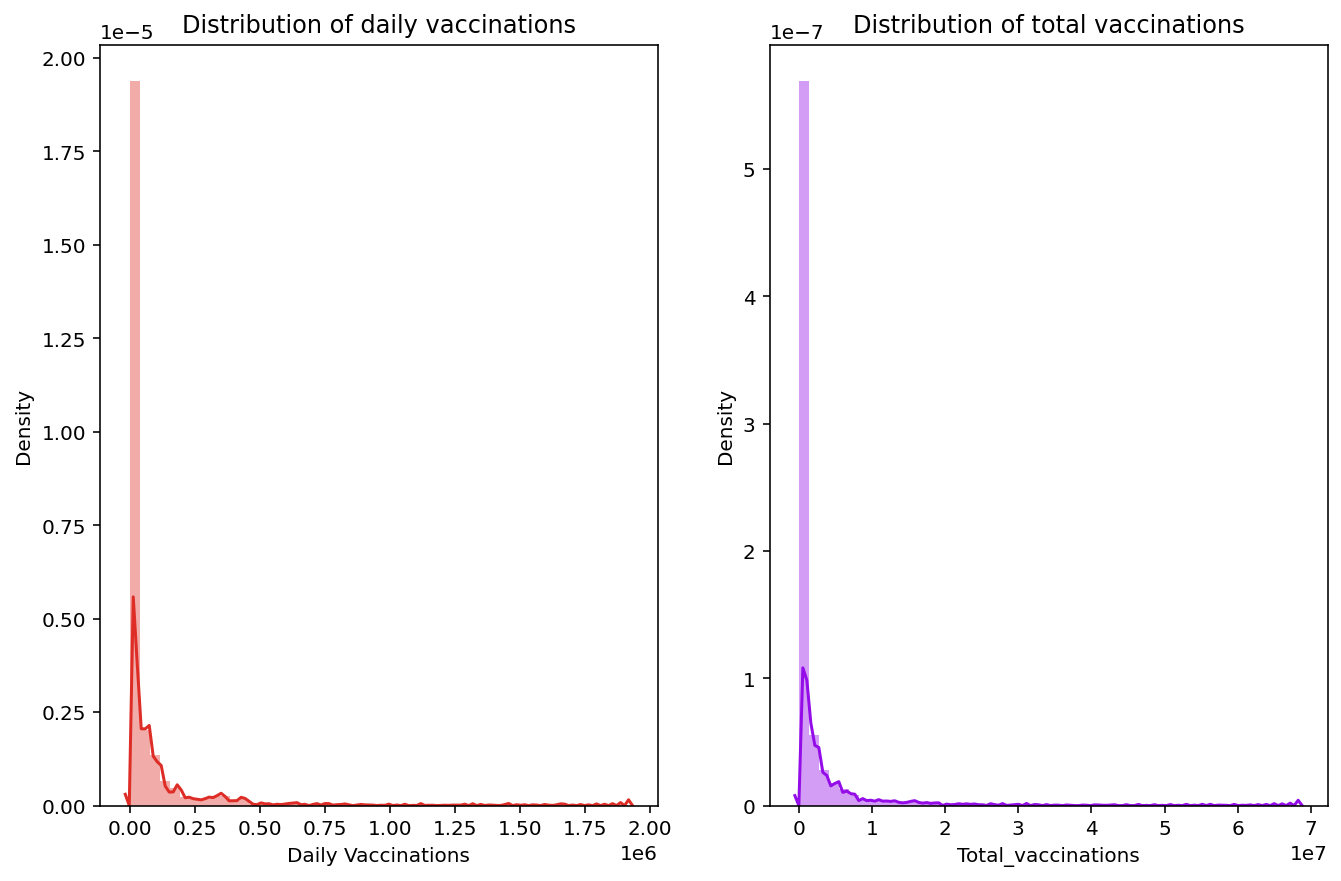

In [21]:
## Take a look at the distribution of daily vaccinated, total vaccinated
plt.subplot(1, 3, 1)
sns.distplot(temp_vaccine['Daily_vaccinations'], color='#DE2D26')
plt.xlabel('Daily Vaccinations')
plt.ylabel('Density')
plt.title("Distribution of daily vaccinations")


plt.subplot(1, 3, 2)
sns.distplot(temp_vaccine['Total_vaccinations'], color='#940CE8');
plt.xlabel('Total_vaccinations')
plt.ylabel('Density')
plt.title("Distribution of total vaccinations")

Plot(1) Distribution of people get vaccine in single day. (Unit:1x10^5 people)<br>
Plot(2) Distribution of total number of people get vaccinated (Unit:1x10^7 people)<br><br>
From the first plot, we can see that the average number of people get vaccinated in one day is around 12,000.In another words,
for most of the countries, based on their current medical capability, they can only provide 12,000 people with vaccines. And from
the second plot, it is revealed that, for each country, the average number of total vaccinations is around 8000,000. If we assume there
are 50,000,000 people in each country, only 1/6 get the vaccines. Hence, from the two graphs above, it can be concluded that the vaccination rate is relatively slow.

In [22]:
##function that sum daily vaccination (input string is the country)
def sum_daily_vaccination(string):
    
    ##filter the dataset
    data = vaccine[vaccine['Country'] == string]
    
    ##drop nan values
    data = data.dropna(subset = ['Daily_vaccinations'])
    count = len(data)-1
    total = 0
    
    ##add them all together
    while(count>0):
        total = total + data.iloc[count]['Daily_vaccinations']
        count = count - 1
        
    ##return the sum
    return total   

In [23]:
##select a few countires and calculate the sum of daily vaccination
result_austria = sum_daily_vaccination('Austria')
result_denmark = sum_daily_vaccination('Denmark')
result_england = sum_daily_vaccination('England')
result_france = sum_daily_vaccination('France')
result_Germany = sum_daily_vaccination('Germany')
result_israel = sum_daily_vaccination('Israel')
result_italy = sum_daily_vaccination('Italy')
result_mexico = sum_daily_vaccination('Mexico')
result_poland = sum_daily_vaccination('Poland')
result_spain = sum_daily_vaccination('Spain')
result_uk = sum_daily_vaccination('United Kingdom')
result_us = sum_daily_vaccination('United States')

In [24]:
##construct a new dataset that contains sum of daily vaccination
data_sum = {'Countries':['Austria','Denmark','England','France','Germany','Israel','Italy','Mexico','Poland','Spain','United Kingdom','United States'],
            'Daily_vaccine_sum':[result_austria,result_denmark,result_england,result_france,result_Germany,result_israel,result_italy,
                                 result_mexico,result_poland,result_spain,result_uk,result_us]}
Daily_vaccine_df = pd.DataFrame(data_sum)

Text(0.5, 1.0, 'Total number of vaccinations for countries')

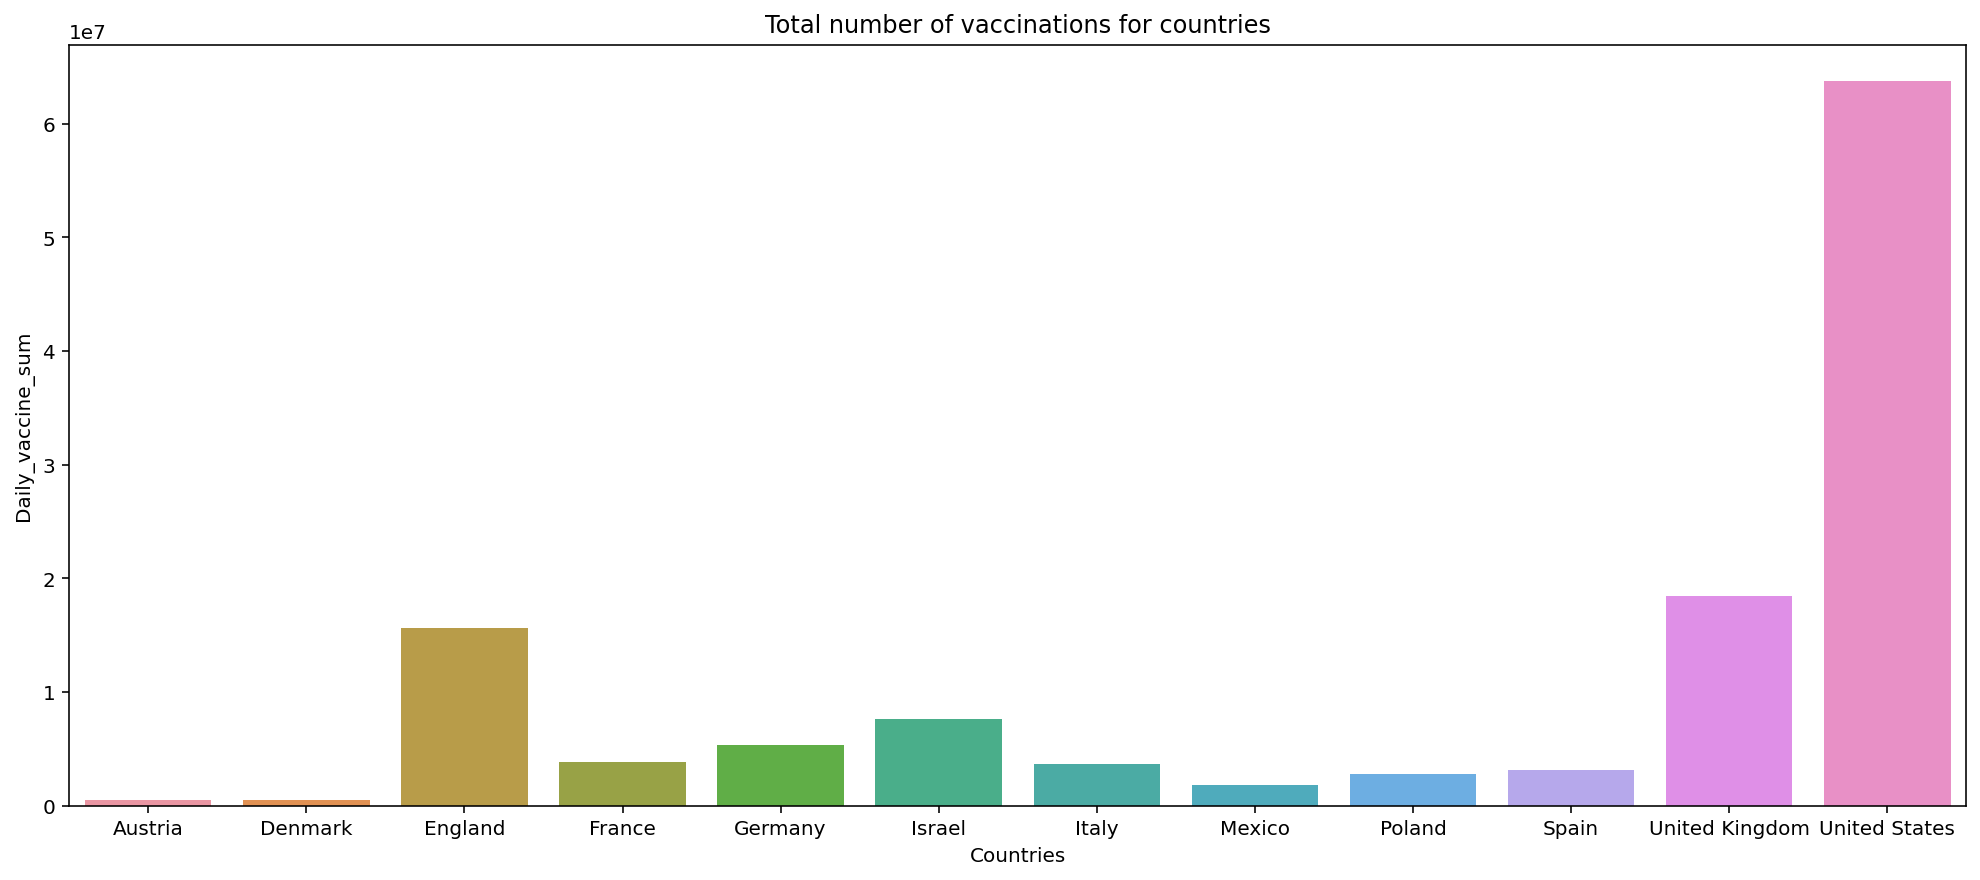

In [25]:
##Using barplot to compare their daily vaccination rate
ax = sns.barplot(x="Countries", y="Daily_vaccine_sum", data=Daily_vaccine_df)
plt.title("Total number of vaccinations for countries")

This plot basically show the total number people get vaccinated in each country. From the plot, we can see that, for small or developing countries, due to their limited medical capability, their vaccination rate were low. However, in big countries like UK or US, they can effectively provide vaccines at a fast speed. Therefore, we can draw the conclusion that the vaccination rate of a country is largely determined by its technological or medical ability.

Text(0.5, 1.0, 'Number of total vaccinatins over time')

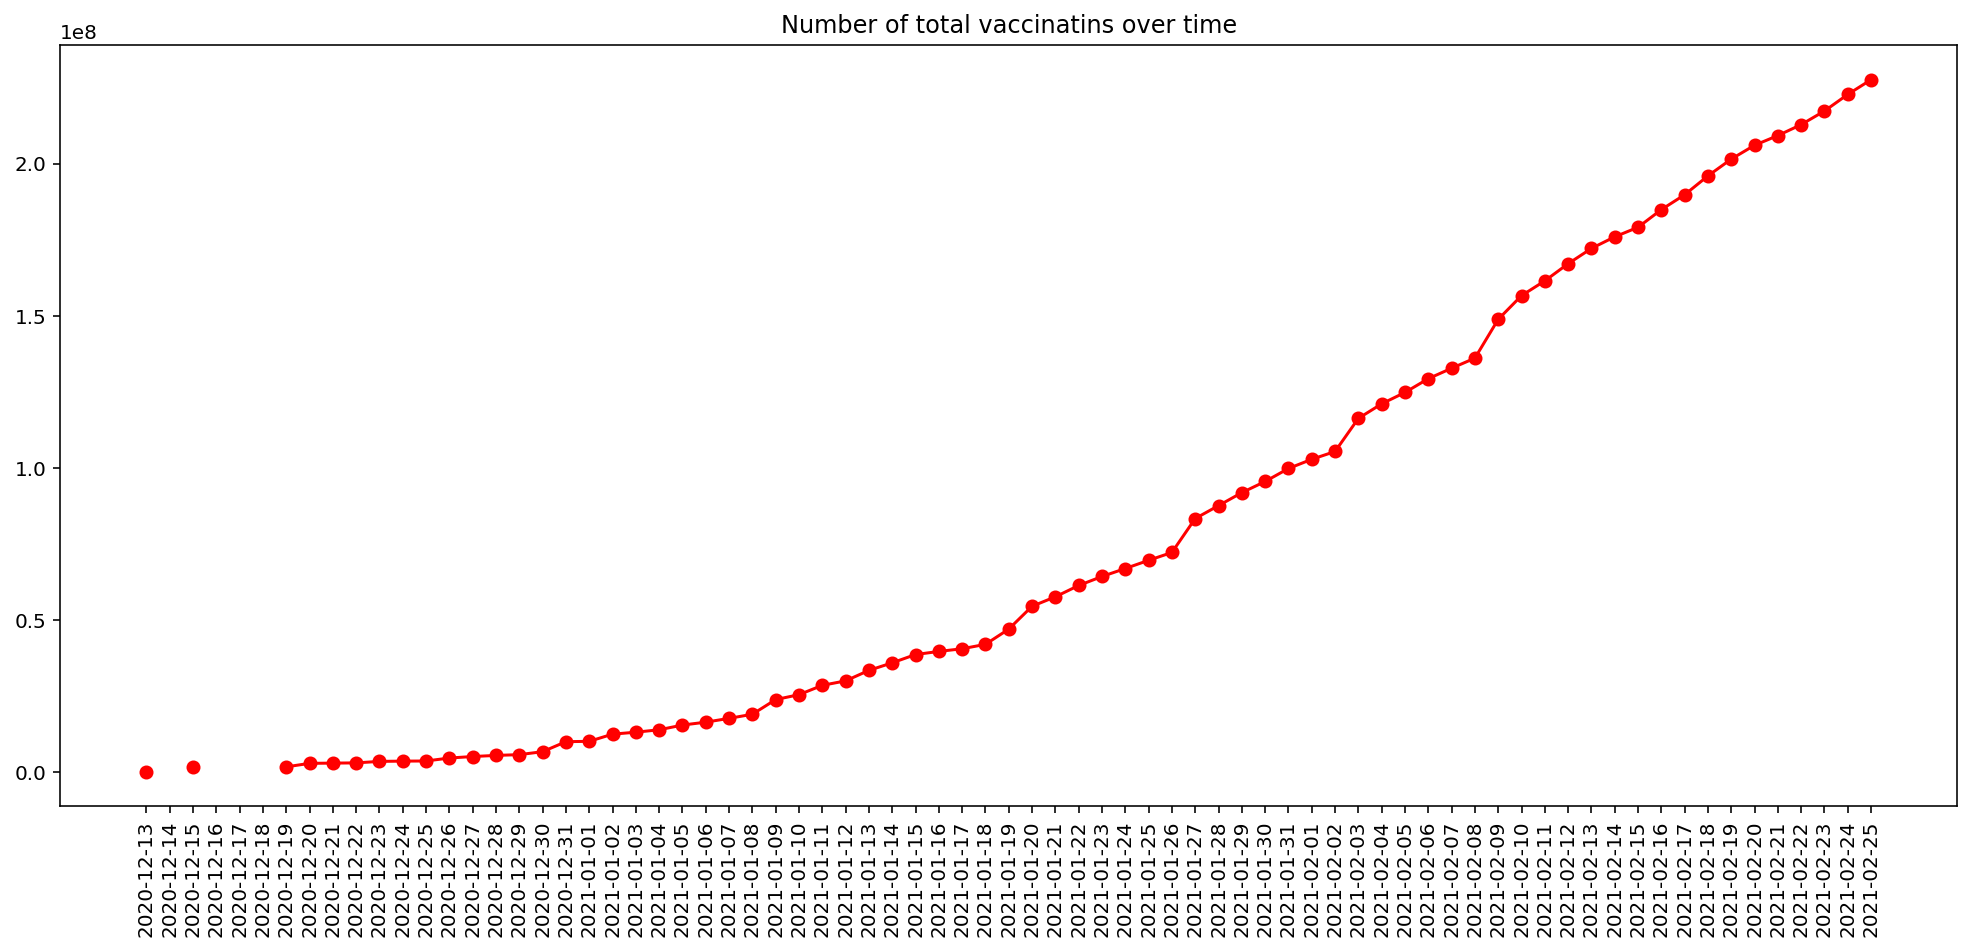

In [26]:
##Total number of vaccines
total_vaccines_date = vaccine[vaccine['Country'] == 'World']
total_vaccines_date = total_vaccines_date[['Date','Total_vaccinations']]

##Plot the number of people get vaccinated over time in the world
plt.xticks(rotation=90)
plt.plot(total_vaccines_date['Date'], total_vaccines_date['Total_vaccinations'], color='red', marker='o')
plt.title("Number of total vaccinatins over time")

From the plot above, we can see that the overall trend of vaccination rate is rising, as vaccines have been distributed around the world and have been put into use on a daily basis. In the later section analyzing the relationship between vaccination rate and new cases, the vaccination rate data will be used again.

## World New Cases Data

For the second step, we would like to explore the `new_cases` dataset on 1) the total number of new cases since 2020-12-13 for continents/countries we are interested in and 2) the change in the number of world new cases over time.

In [27]:
# Take a look at new_cases
new_cases.head()

,Date,World,Afghanistan,Africa,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,...,United States,Uruguay,Uzbekistan,Vanuatu,Vatican,Venezuela,Vietnam,Yemen,Zambia,Zimbabwe
0,2020-12-13,544274.0,298.0,16222.0,788.0,464.0,50.0,27.0,0.0,3558.0,...,187429.0,528.0,145.0,0.0,0.0,609.0,2.0,0.0,57.0,27.0
1,2020-12-14,523954.0,191.0,11318.0,661.0,495.0,44.0,89.0,0.0,5062.0,...,193151.0,321.0,138.0,0.0,0.0,339.0,5.0,1.0,48.0,112.0
2,2020-12-15,636389.0,234.0,18002.0,809.0,468.0,0.0,85.0,0.0,6981.0,...,209189.0,389.0,147.0,0.0,0.0,355.0,3.0,1.0,106.0,164.0
3,2020-12-16,732766.0,209.0,21225.0,637.0,442.0,64.0,45.0,3.0,6843.0,...,245740.0,475.0,297.0,0.0,0.0,237.0,0.0,0.0,28.0,227.0
4,2020-12-17,738690.0,217.0,20508.0,787.0,426.0,20.0,77.0,0.0,7326.0,...,239077.0,543.0,0.0,0.0,0.0,364.0,2.0,2.0,48.0,117.0


In [28]:
# Determine the column names
new_cases.columns

Index(['Date', 'World', 'Afghanistan', 'Africa', 'Albania', 'Algeria',
       'Andorra', 'Angola', 'Antigua and Barbuda', 'Argentina',
       ...
       'United States', 'Uruguay', 'Uzbekistan', 'Vanuatu', 'Vatican',
       'Venezuela', 'Vietnam', 'Yemen', 'Zambia', 'Zimbabwe'],
      dtype='object', length=200)

In [29]:
# Determine the data types
new_cases.dtypes

Date           datetime64[ns]
World                 float64
Afghanistan           float64
Africa                float64
Albania               float64
                    ...      
Venezuela             float64
Vietnam               float64
Yemen                 float64
Zambia                float64
Zimbabwe              float64
Length: 200, dtype: object

In [30]:
# Describe the statistics again
new_cases.describe()

,World,Afghanistan,Africa,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,...,United States,Uruguay,Uzbekistan,Vanuatu,Vatican,Venezuela,Vietnam,Yemen,Zambia,Zimbabwe
count,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,...,60.000000,60.000000,60.000000,60.0,60.0,60.000000,60.000000,60.000000,60.000000,60.000000
mean,591235.183333,119.550000,22384.850000,682.150000,302.400000,51.066667,67.483333,3.366667,8440.533333,353.066667,...,184422.850000,626.633333,73.766667,0.0,0.0,404.983333,11.600000,0.833333,789.266667,394.083333
std,123315.532909,194.260914,6903.109564,245.278246,96.428106,30.371076,32.853291,6.305679,3135.294269,267.908084,...,52755.620332,211.502852,49.031766,0.0,0.0,121.651000,21.693708,1.122447,555.316488,330.767740
min,315510.000000,0.000000,11318.000000,0.000000,0.000000,0.000000,14.000000,0.000000,0.000000,58.000000,...,89581.000000,321.000000,0.000000,0.0,0.0,147.000000,0.000000,0.000000,28.000000,27.000000
25%,514223.000000,46.000000,16759.500000,538.000000,244.500000,35.000000,41.500000,0.000000,6431.500000,157.750000,...,145599.000000,509.750000,45.750000,0.0,0.0,324.500000,1.000000,0.000000,233.750000,122.750000
50%,589404.000000,76.500000,21242.500000,660.500000,262.500000,48.500000,68.000000,0.500000,8203.500000,285.000000,...,188790.500000,586.000000,59.500000,0.0,0.0,412.000000,3.000000,0.000000,857.500000,283.000000
75%,692467.250000,141.000000,27373.000000,867.750000,396.500000,64.000000,89.000000,3.000000,10896.500000,457.250000,...,227323.250000,683.000000,100.750000,0.0,0.0,474.750000,9.250000,1.250000,1260.250000,651.500000
max,858062.000000,1485.000000,36473.000000,1239.000000,495.000000,141.000000,188.000000,34.000000,13835.000000,1174.000000,...,300282.000000,1514.000000,297.000000,0.0,0.0,673.000000,110.000000,5.000000,1796.000000,1365.000000


We will first calculate the total number of new cases for the six continents included in the dataset, and we will store those values in a new dataframe to generate a barplot for comparison. In this part, we are getting a sense of the COVID condition around the world.

In [31]:
# Select the six continents and calculate the total number of new cases
total_new_africa = new_cases["Africa"].sum()
total_new_asia = new_cases["Asia"].sum()
total_new_australia = new_cases["Australia"].sum()
total_new_europe = new_cases["Europe"].sum()
total_new_namerica = new_cases["North America"].sum()
total_new_samerica = new_cases["South America"].sum()

In [32]:
# Construct a new dataframe that contains total number of new cases for the six continents
continent_df = {"Continent":["Africa", "Asia", "Australia", "Europe", "North America", "South America"],
      "Total New Cases since 2020-12-13":[total_new_africa, total_new_asia, total_new_australia, total_new_europe, 
                                          total_new_namerica, total_new_samerica]}
continent_total_new_cases = pd.DataFrame(continent_df)
continent_total_new_cases

,Continent,Total New Cases since 2020-12-13
0,Africa,1343091.0
1,Asia,4780918.0
2,Australia,849.0
3,Europe,12102502.0
4,North America,12538535.0
5,South America,4707794.0


Text(0.5, 1.0, 'Total number of new cases for six continents since 2020-12-13')

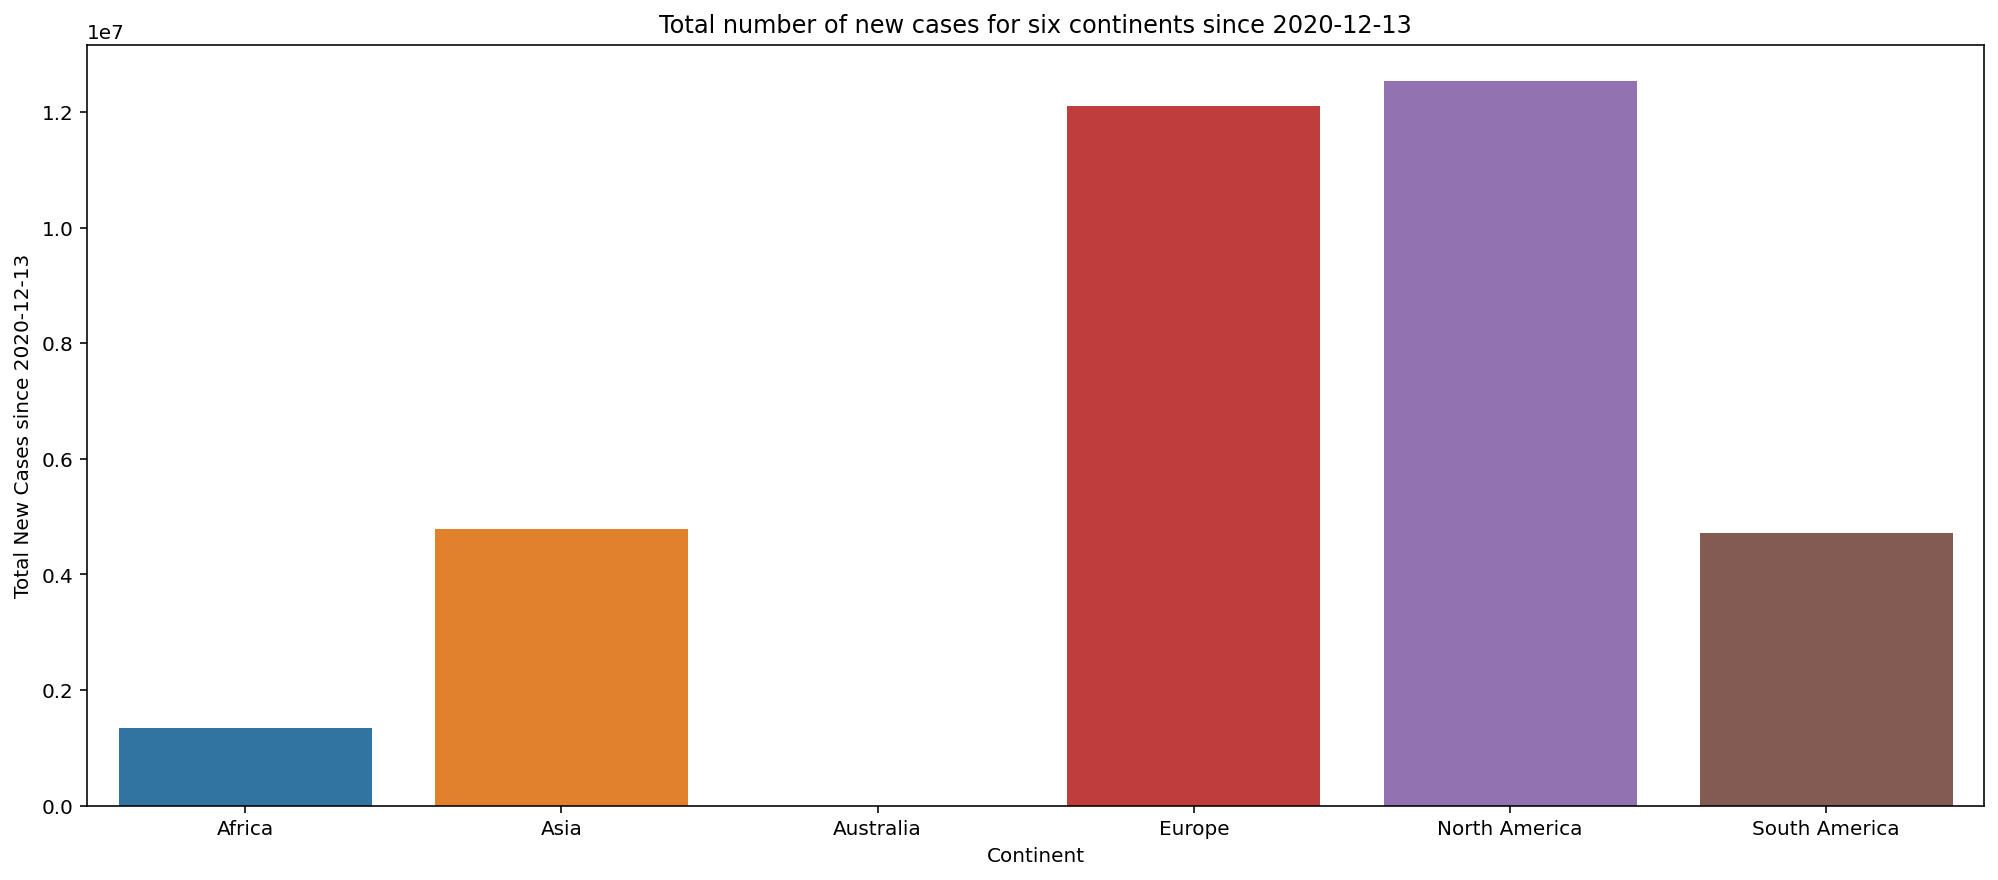

In [33]:
# Generate a barplot to compare the total number of new cases across six continents
sns.barplot(x = "Continent", y = "Total New Cases since 2020-12-13", data = continent_total_new_cases)
plt.title("Total number of new cases for six continents since 2020-12-13")

After exploring the data for the six continents, we would like to choose some representative countries in each continent to repeat the steps of calculating the total number of new cases, storing values into a new dataframe, and generating a barplot for conparison.

In [34]:
# Select some countries we are interested in and calculate the total number of new cases
total_new_safrica = new_cases["South Africa"].sum()
total_new_china = new_cases["China"].sum()
total_new_japan = new_cases["Japan"].sum()
total_new_australia = new_cases["Australia"].sum()
total_new_uk = new_cases["United Kingdom"].sum()
total_new_france = new_cases["France"].sum()
total_new_germany = new_cases["Germany"].sum()
total_new_us = new_cases["United States"].sum()
total_new_canada = new_cases["Canada"].sum()
total_new_brazil = new_cases["Brazil"].sum()

In [35]:
# Construct a new dataframe that contains total number of new cases for selected countries
country_df = {"Country":["South Africa", "China", "Japan", "Australia", "United Kingdom", "France", "Germany", 
                           "United States", "Canada", "Brazil"],
              "Total New Cases since 2020-12-13":[total_new_safrica, total_new_china, total_new_japan, 
                                                  total_new_australia, total_new_uk, total_new_france, 
                                                  total_new_germany, total_new_us, total_new_canada, total_new_brazil]}
country_total_new_cases = pd.DataFrame(country_df)
country_total_new_cases

,Country,Total New Cases since 2020-12-13
0,South Africa,629447.0
1,China,6277.0
2,Japan,232162.0
3,Australia,849.0
4,United Kingdom,2160884.0
5,France,1037809.0
6,Germany,975196.0
7,United States,11065371.0
8,Canada,360228.0
9,Brazil,2779040.0


Text(0.5, 1.0, 'Total number of new cases for selected countries since 2020-12-13')

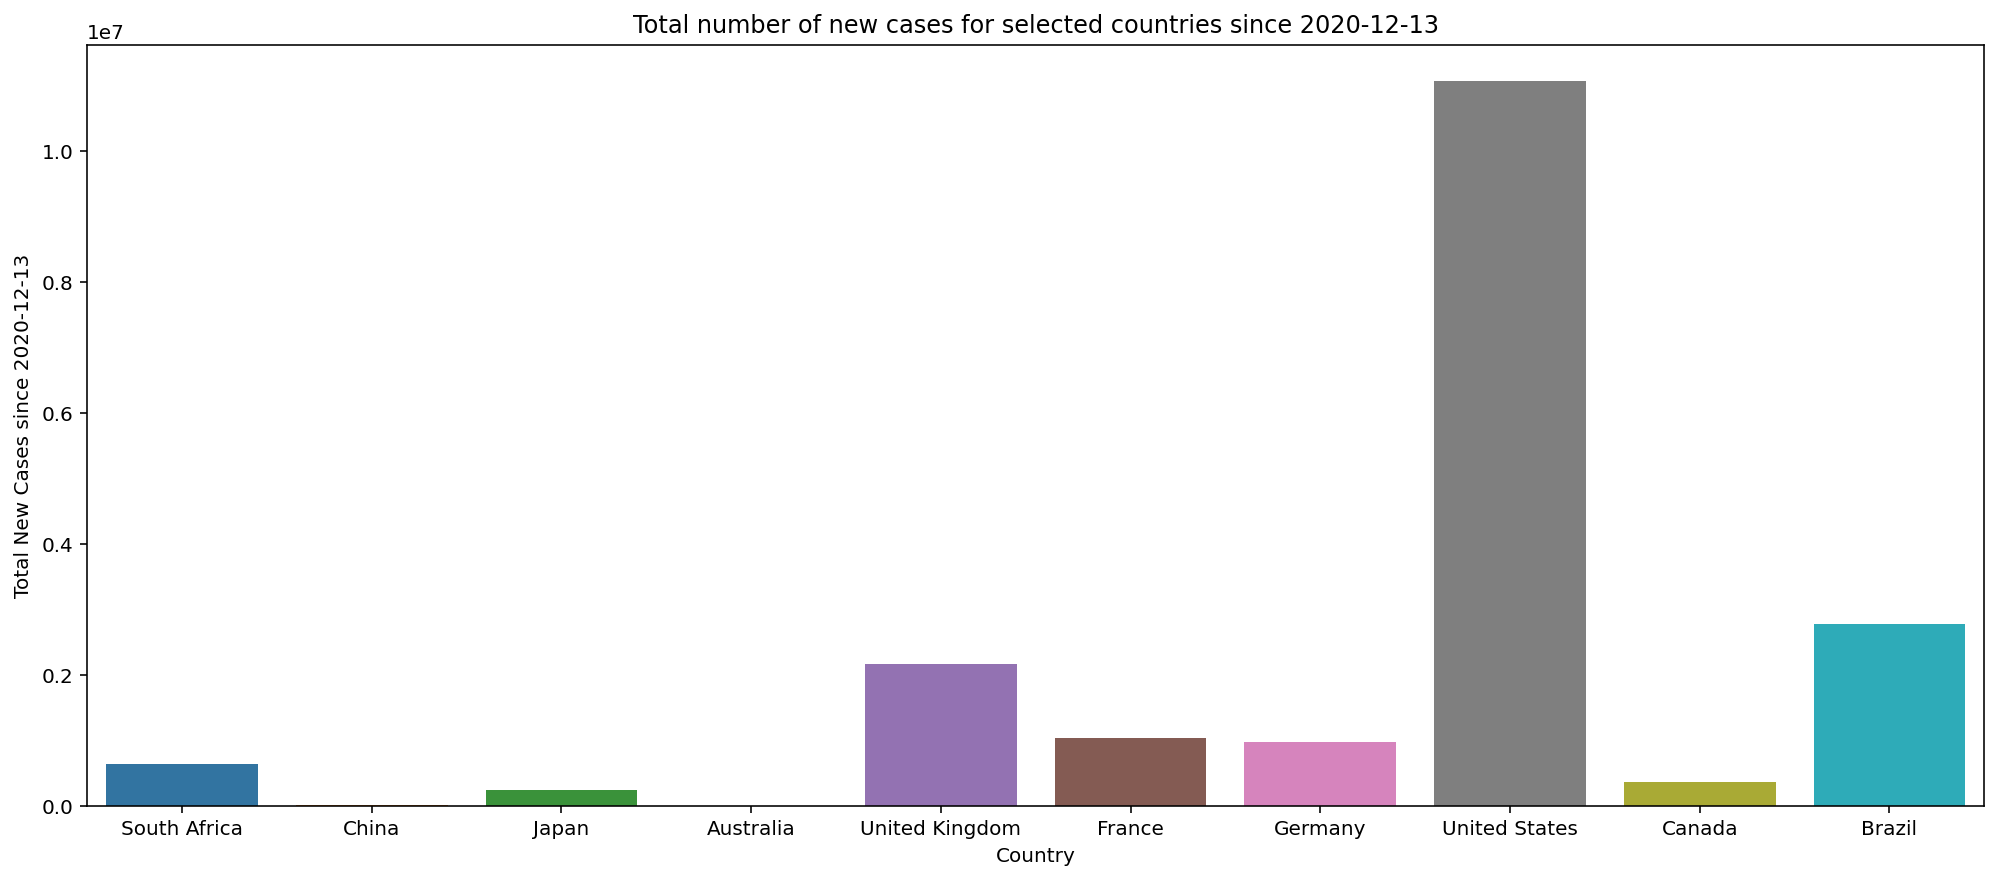

In [36]:
# Generate a barplot to compare the total number of new cases across selected countries
sns.barplot(x = "Country", y = "Total New Cases since 2020-12-13", data = country_total_new_cases)
plt.title("Total number of new cases for selected countries since 2020-12-13")

In this bar plot, we can see that the US has a very large number of total new cases, suggesting that the condition might be out of control recently. Therefore, we would like to explore the change in new cases over time for US specifcally to see the reason behind it.

Text(0, 0.5, 'Number of New Cases')

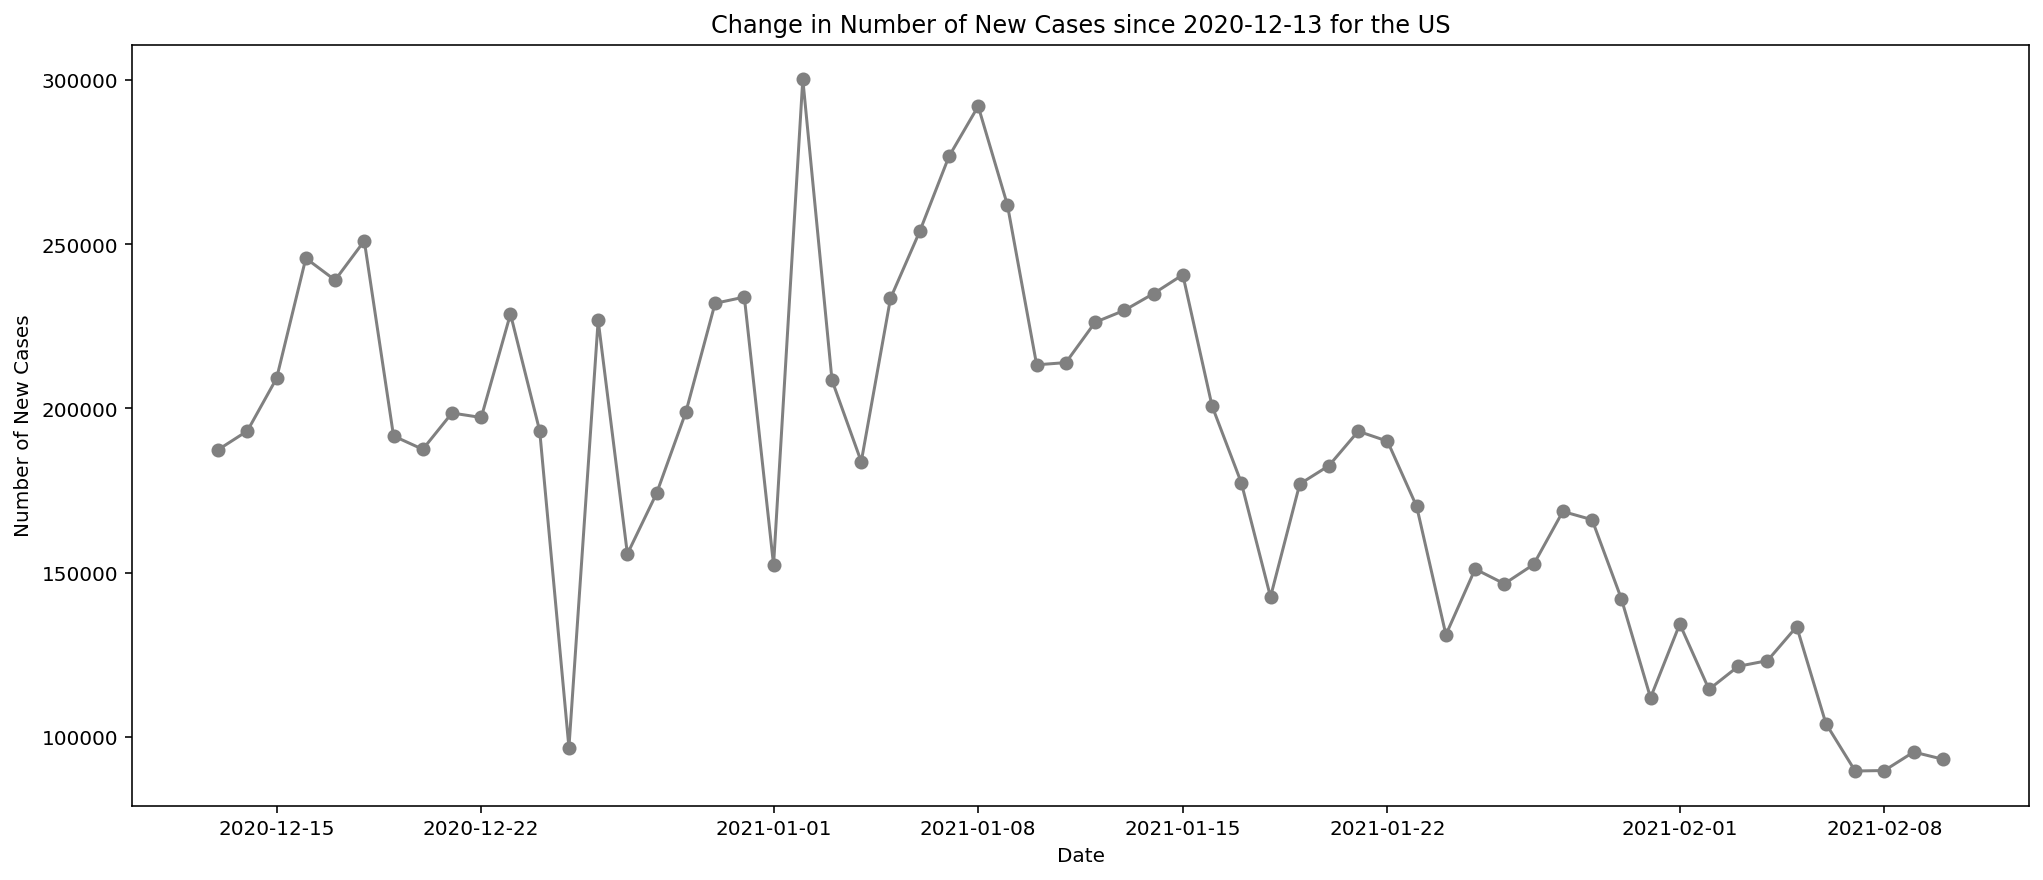

In [37]:
# Plot the change in number of new cases over time for the US
plt.plot(new_cases["Date"], new_cases["United States"], color="gray", marker='o')
plt.title("Change in Number of New Cases since 2020-12-13 for the US")
plt.xlabel("Date")
plt.ylabel("Number of New Cases")

Text(0, 0.5, 'Number of New Cases')

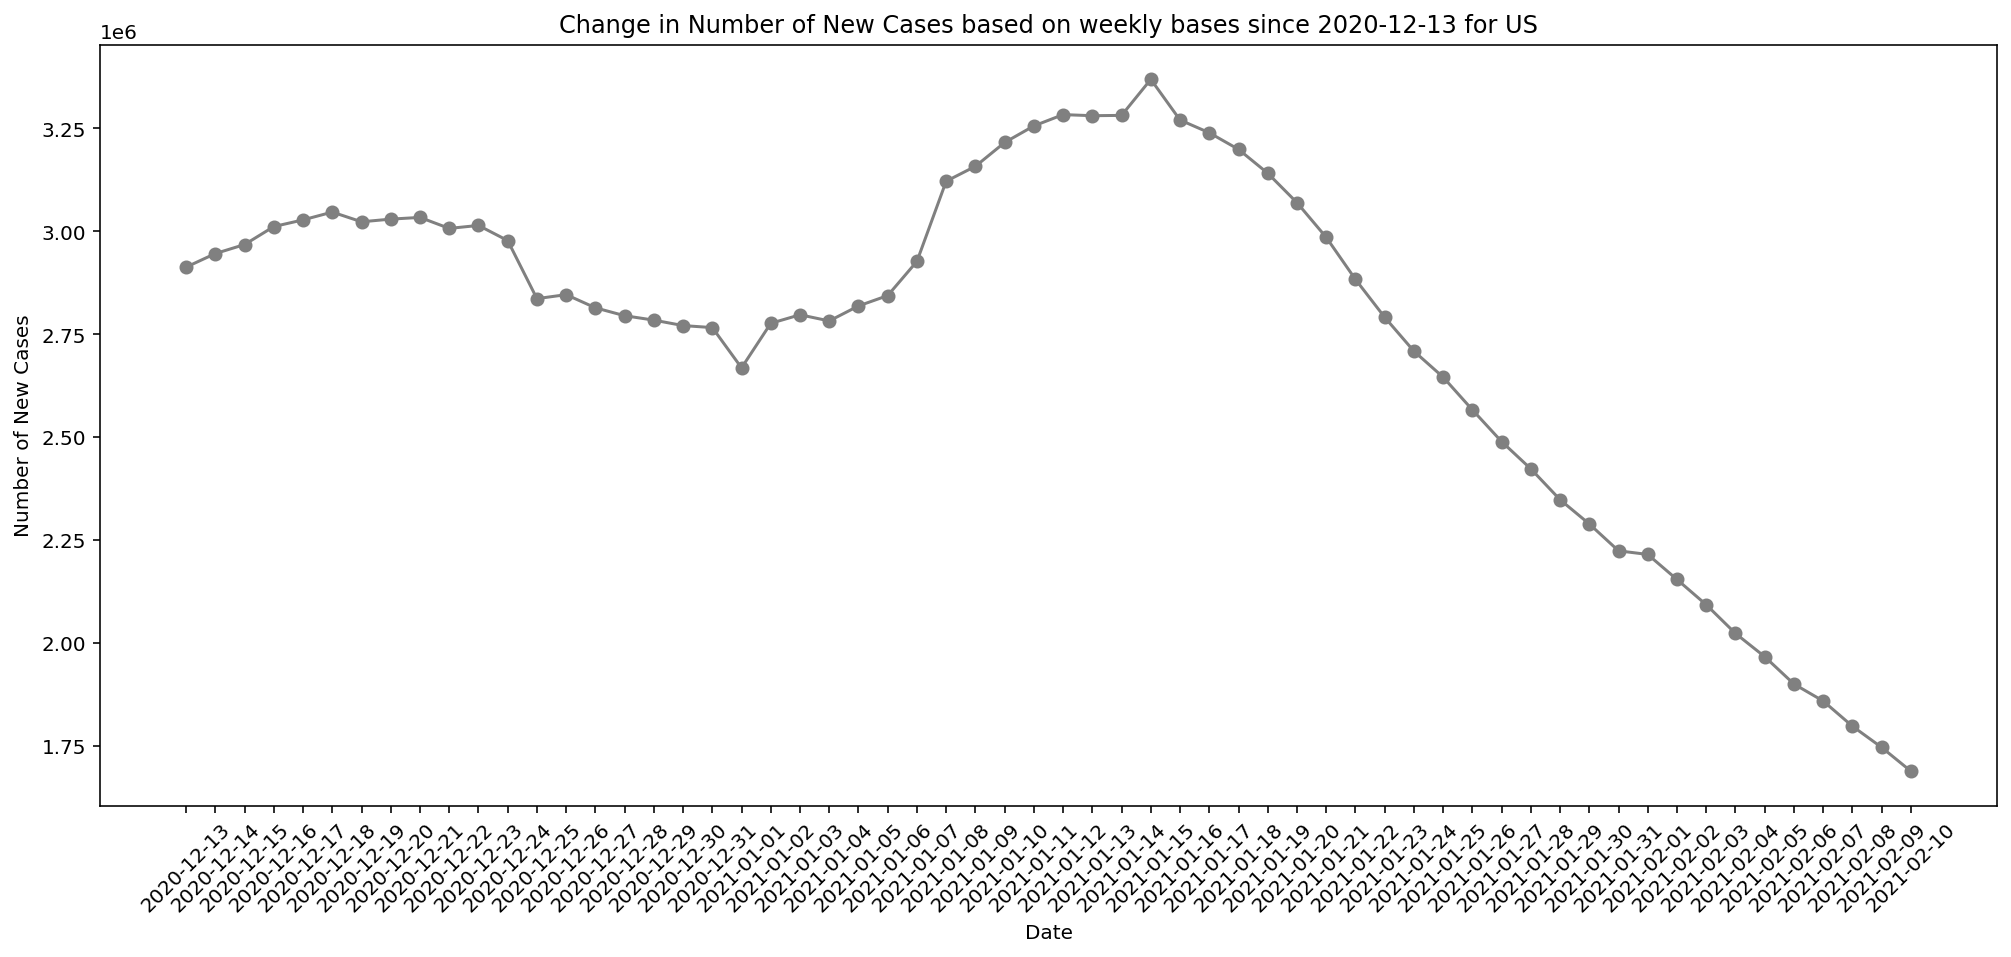

In [46]:
# Give the plot of the change in number of new cases over week for US
plt.xticks(rotation = 45)
plt.plot(weekly_data["Date"], weekly_data["United States"], color="gray", marker='o')
plt.title("Change in Number of New Cases based on weekly bases since 2020-12-13 for US")
plt.xlabel("Date")
plt.ylabel("Number of New Cases")

From these two plots (daily based and weekly based), we could see the overall trend of new cases in the US is in fact decreasing, notably since 2021-01-15, instead of being out of control. Therefore, even though the total number of new cases for the US is much larger than other countries, it might due to a large base of confirmed cases before the use of vaccines. Since the day vaccinations has started, the US has also responded to it as there have been less new cases recently. We suggest that the vaccines are starting to have the effect.

With a sense of the global COVID condition since the first day of reported vaccination data, we would like to illustrate the change in the number of world new cases over time also since that day.

Text(0, 0.5, 'Number of World New Cases')

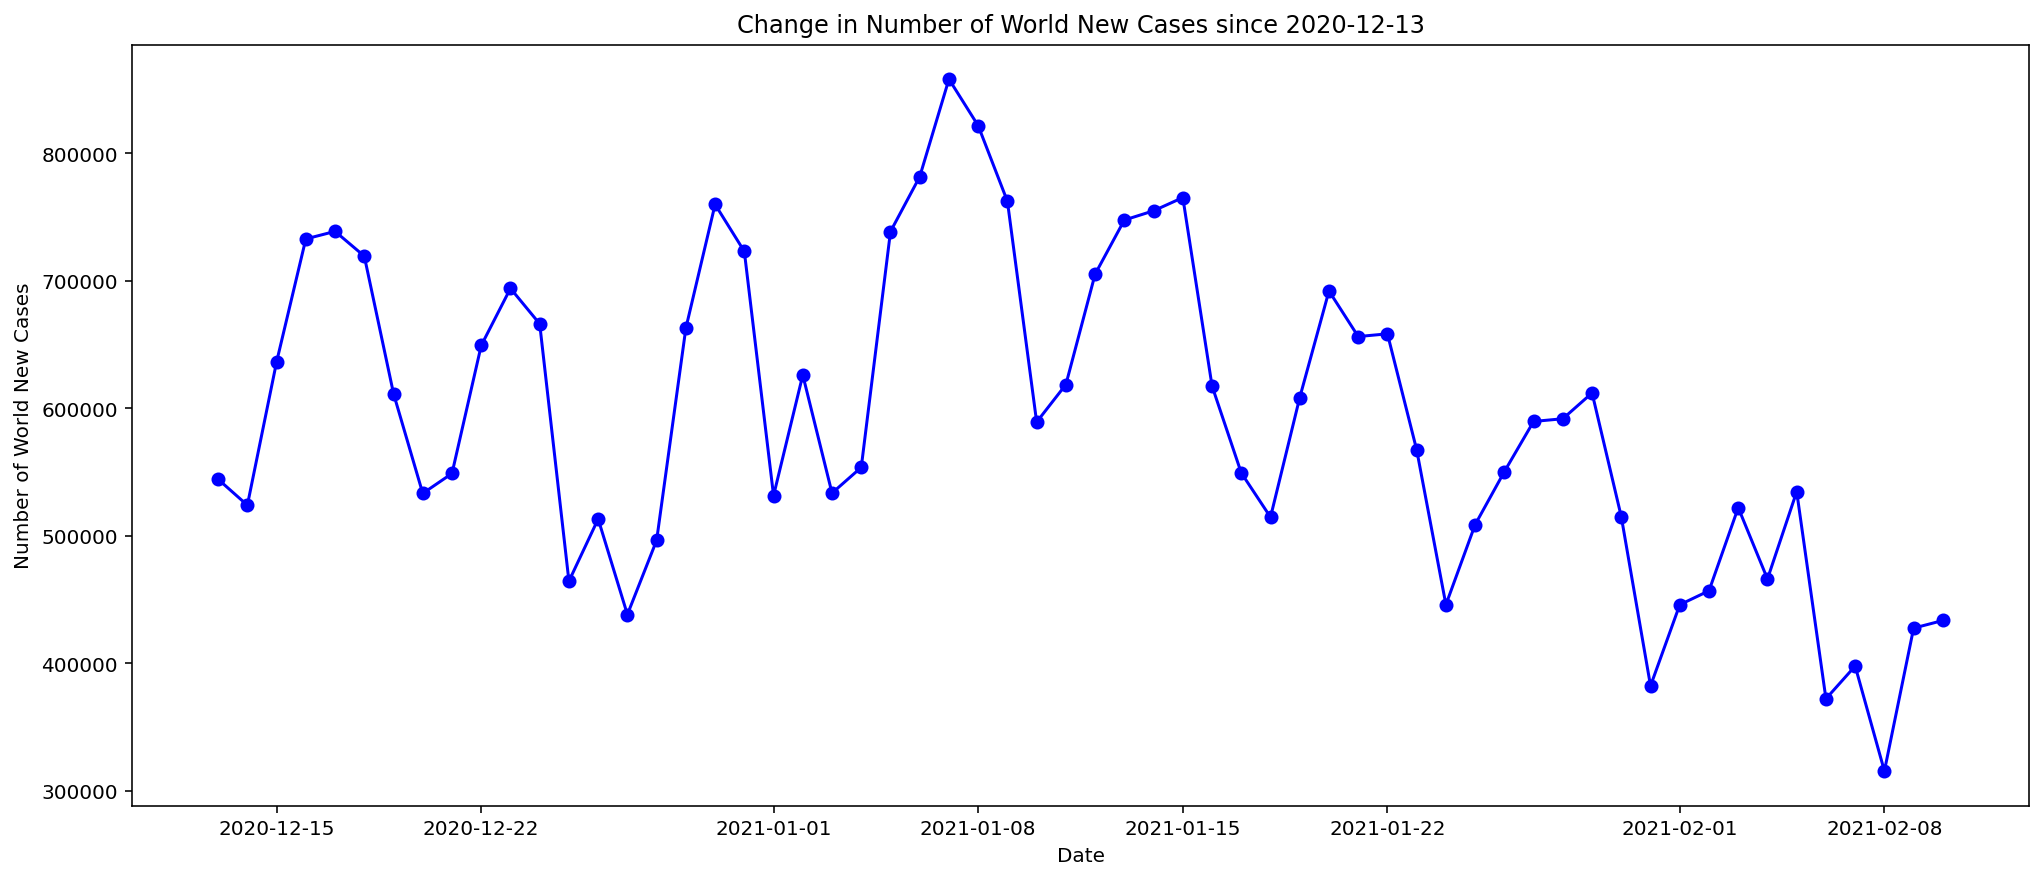

In [39]:
# Plot the change in number of world new cases over time
plt.plot(new_cases['Date'], new_cases['World'], color='blue', marker='o')
plt.title("Change in Number of World New Cases since 2020-12-13")
plt.xlabel("Date")
plt.ylabel("Number of World New Cases")

Text(0, 0.5, 'Number of World New Cases')

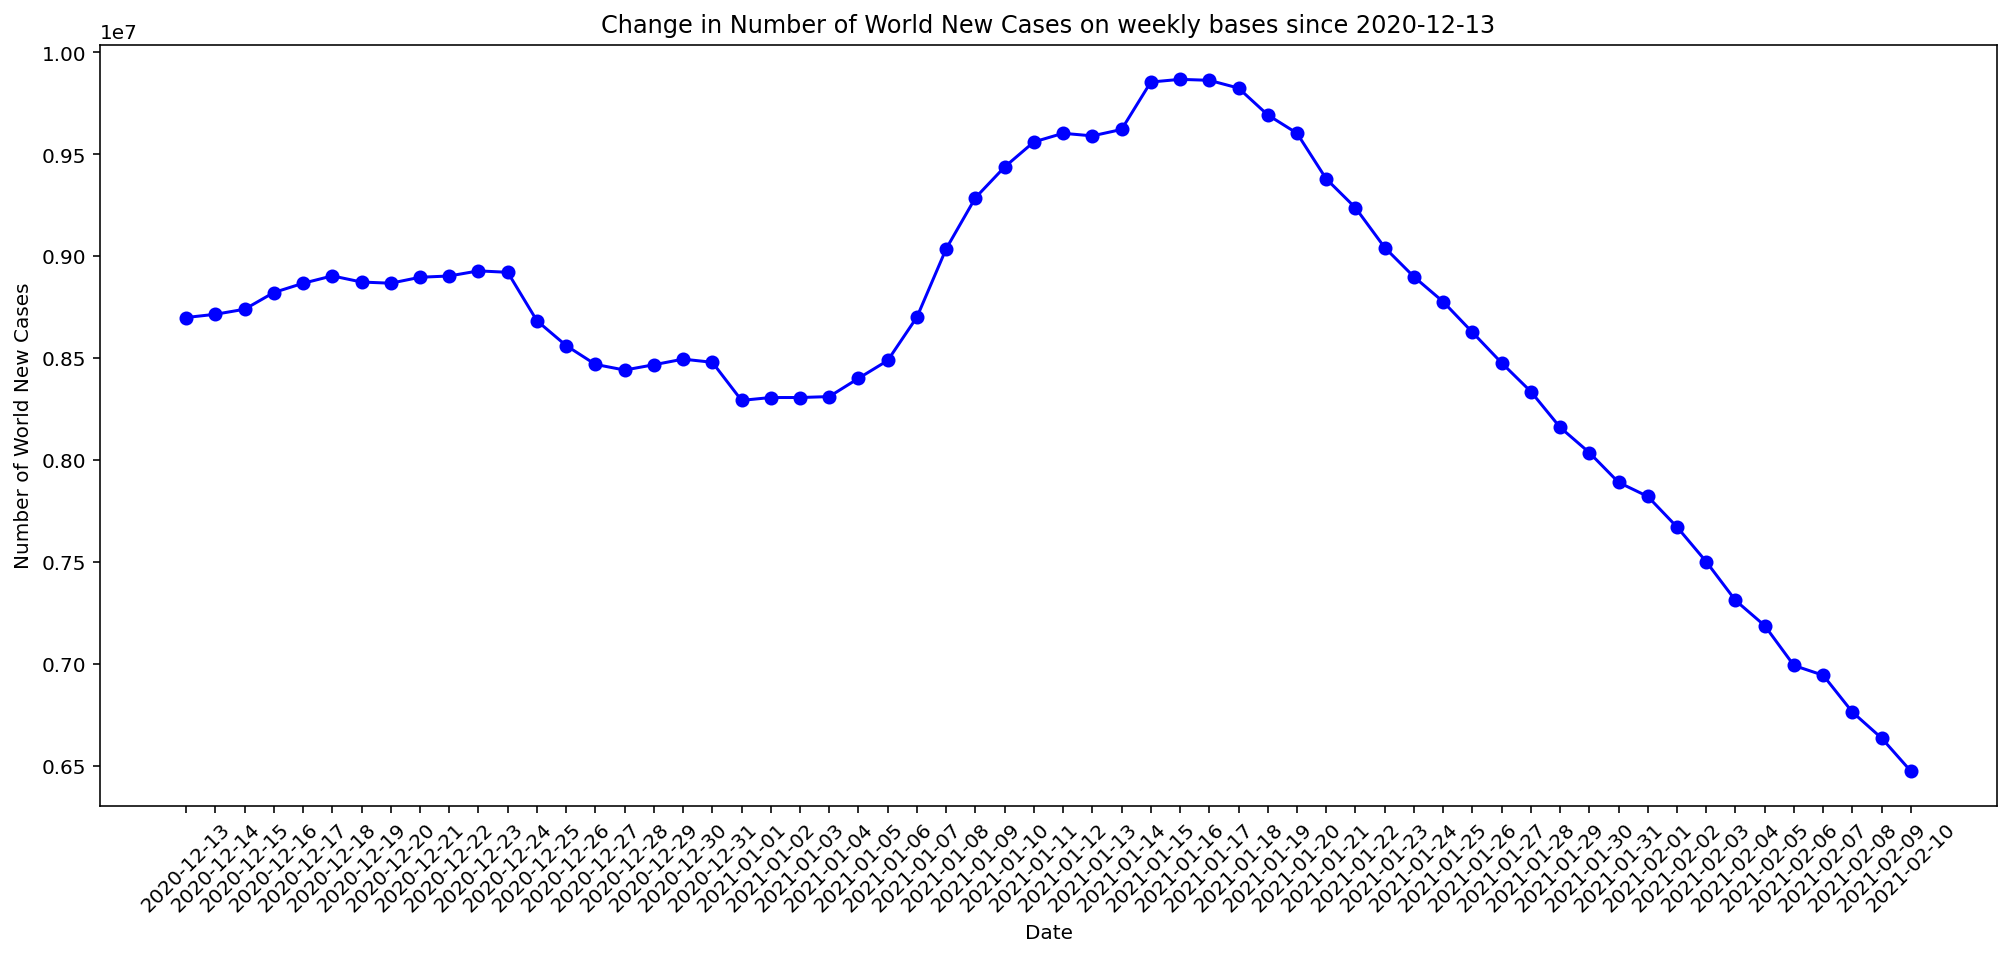

In [45]:
# Give the plot of the change in number of world new cases over week
plt.xticks(rotation = 45)
plt.plot(weekly_data['Date'], weekly_data['World'], color='blue', marker='o')
plt.title("Change in Number of World New Cases on weekly bases since 2020-12-13")
plt.xlabel("Date")
plt.ylabel("Number of World New Cases")

From these two plots, we could see the overall trend of new cases is decreasing (Either from dayily base or weekly base). Even though there are some fluctations, the overall trend is still down, notably since 2021-01-15. Therefore, the vaccines are starting to have the effect in not only the US but also countries around the world. In the next section, we will use a linear regression to find out the relationship between these two factors.

Also, through the plots above, We can see that the weekly graph has a larger effect than the daily graph, that is, the number of people diagnos(ed per week （second graph) has a more significant downward trend than the number of people diagnosed per day(first garph). This suggests that in the long term, the number of diagnoses is falling steadily.

## Relationship between Datasets

Text(0.5, 1.0, 'Relationship between vaccination rate and new confirmed cases')

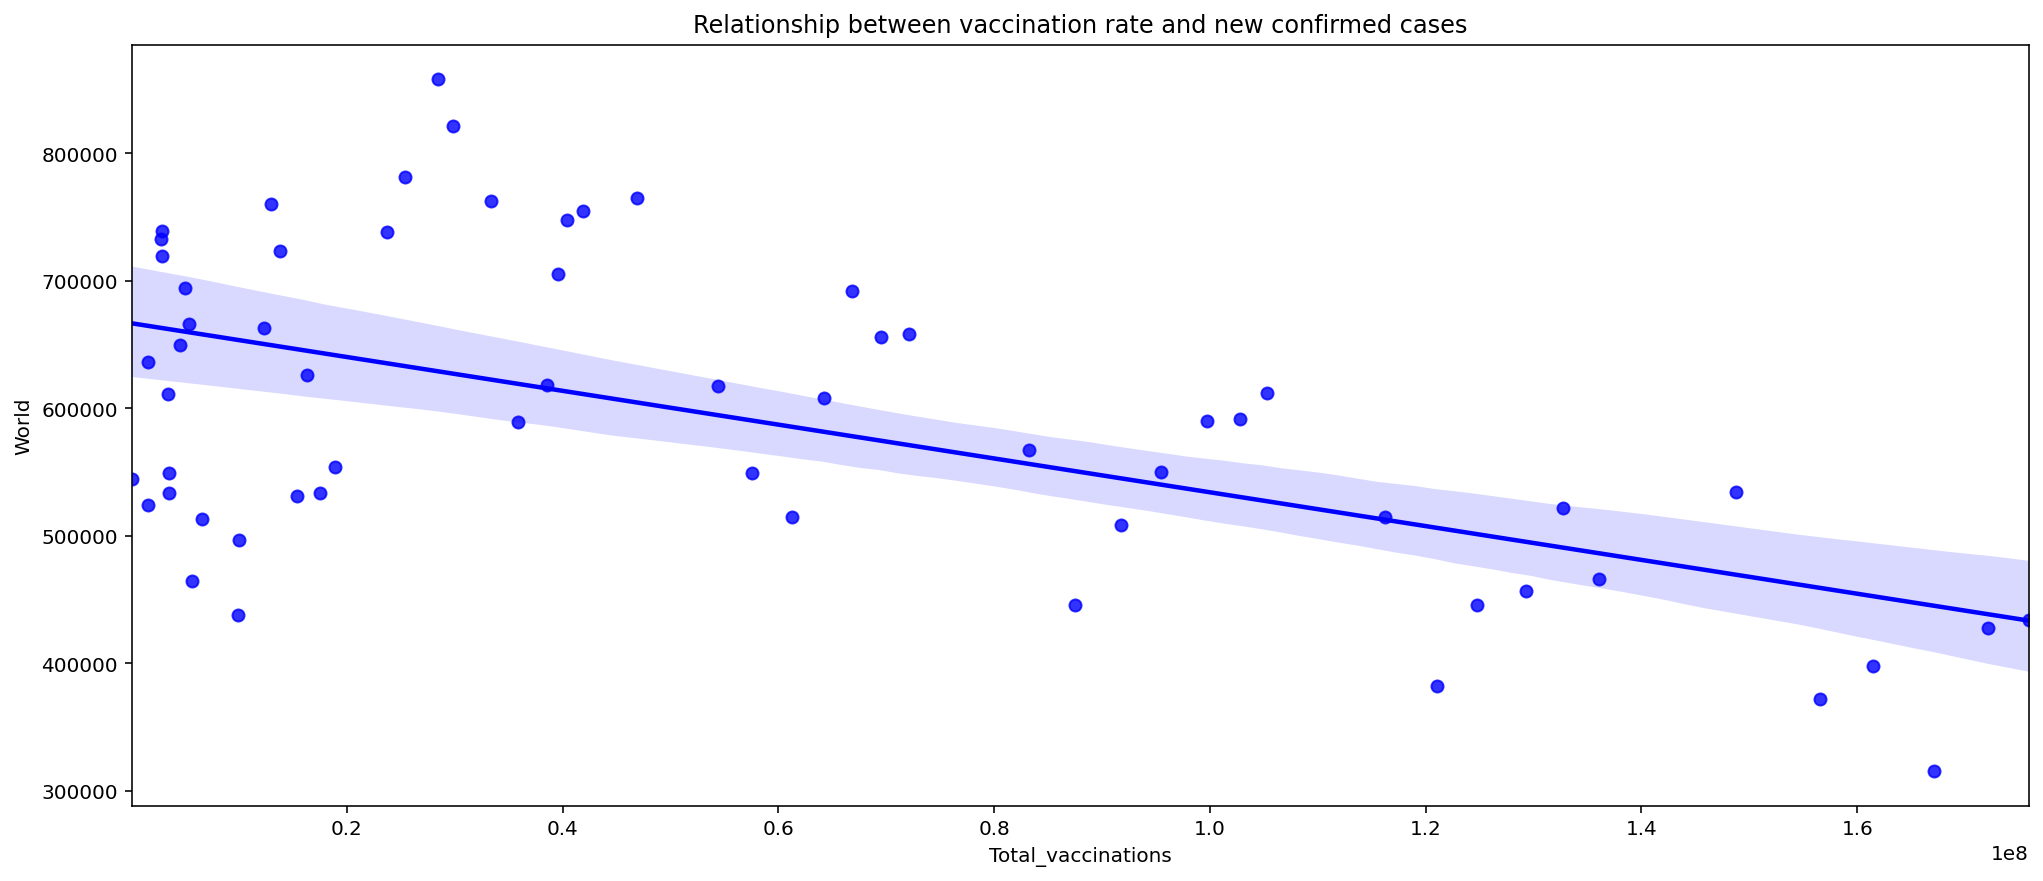

In [41]:
##new cases in the whole world
new_cases_temp = new_cases[['World']]

##total vaccination number for the world 
total_vaccines = vaccine[vaccine['Country'] == 'World']
total_vaccines = total_vaccines['Total_vaccinations']
total_vaccines = total_vaccines.dropna()

##merge two datasets
total_vaccines.drop(total_vaccines.index[[0, 1, 2]],axis=0)
total_vaccines = total_vaccines.reset_index()
total_vaccines['World'] = new_cases_temp['World']

##show their relationships
sns.regplot(x='Total_vaccinations', y='World', data=total_vaccines, color='blue')
plt.title("Relationship between vaccination rate and new confirmed cases")

This plot shows the relationship between vaccination rate and new confirmed cases. From the regression line above, it can be seen that there is a roughly negative linear relationship. In another word, as the number of vaccinations increase, the number of new confirmed cases will decrease. And based on the distribution of these datapoints, this relationship is kind of strong. The regression here may prove our initial hypothesis is correct, but it still need further test analysis to measure whether it is significant enough.

In [42]:
# Linear model
outcome, predictors = patsy.dmatrices('World ~ Total_vaccinations', total_vaccines)
model = sm.OLS(outcome, predictors)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                  World   R-squared:                       0.337
Model:                            OLS   Adj. R-squared:                  0.325
Method:                 Least Squares   F-statistic:                     29.46
Date:                Sat, 27 Feb 2021   Prob (F-statistic):           1.17e-06
Time:                        11:34:51   Log-Likelihood:                -775.66
No. Observations:                  60   AIC:                             1555.
Df Residuals:                      58   BIC:                             1560.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           6.667e+05   1.91

After fitting a linear model for our predictor and outcome, we observe...

# Project Proposal (updated)

| Meeting Date  | Meeting Time| Completed Before Meeting  | Discuss at Meeting |
|---|---|---|---|
| 1/14  | 6 PM  | Form a group of four | Edit, finalize, and submit Project Planning Survey (Due 1/15 11:59pm) |
| 1/21  | 6 PM  | Review the assigned previous project | Edit, finalize, and submit Previous Project Review (Due 1/22 11:59pm) |
| 1/28  |  6 PM | Read & Think about COGS 108 expectations; brainstorm topics/questions/hypothesis; Do background and dataset research; Begin drafting the project proposal; | Edit, finalize, and submit Project Proposal (Due 1/29 11:59pm) | 
| 2/4  | 6 PM  | Explore the datasets; Think about possible wrangling & analysis approaches | Discuss the approaches; Assign group members to lead each specific part |
| 2/11  | 6 PM  | Begin data wrangling | Address any issues encountered; Edit, finalize, and submit Checkpoint #1: Data (Due 2/12 11:59pm) |
| 2/18  | 6 PM  | Begin data analysis & results| Address any issues encountered |
| 2/25  | 6 PM  | Continue data analysis & results; Begin drafting conclusions/discussions | Address any issues encountered; Edit, finalize, and submit Checkpoint #2: EDA (Due 2/26 11:59pm) |
| 3/4  | 6 PM  | Continue drafting conclusions/discussions | Address any issues encountered; Discuss improvements; Plan video recording |
| 3/11  | 6 PM  | Prepare scripts for the final video | Record the final video |
| 3/14  | 6 PM  | Check everything  | Edit, finalize, and submit Final Report, Final Video, and Team Evaluation (Due 3/17 11:59pm) |